In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d
import multiprocessing as mp
import emcee
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

In [2]:
# =========================
# Leitura dos dados SNe
# =========================

# caminhos
sne_dat_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/SNe/Pantheon+SH0ES.dat"
sne_cov_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/SNe/Pantheon+SH0ES_STAT+SYS.cov"

# tabela
df_sne = pd.read_csv(sne_dat_path, sep=r"\s+", comment="#", engine="python")

# carregar covariancia
raw_cov = np.loadtxt(sne_cov_path, skiprows=1)
Cov_sne_full = raw_cov.reshape((1701, 1701))

# aplicar corte em z > 0.01
mask = df_sne["zCMB"].values > 0.01
df_cut = df_sne[mask].reset_index(drop=True)
Cov_sne = Cov_sne_full[mask, :][:, mask]

# colunas z_obs e mB_obs_corrigido
z_sne = df_cut["zCMB"].values
mB_obs = df_cut["m_b_corr"].values

# cálculo da matriz inversa
Cinv_sne = np.linalg.inv(Cov_sne)

z_sne

array([0.01029, 0.01051, 0.01051, ..., 1.80111, 1.9116 , 2.2613 ],
      shape=(1588,))

In [3]:
# ===============================
# Fiducial
# ===============================

# Priors uniformes
H0_min, H0_max = 50., 90.
Om0_min, Om0_max = 0.1, 0.6
w0_min, w0_max = -3.0, 1.0
wa_min, wa_max = -2.0, 1.0

# Prios gaussianos
mu_MB, sigma_MB = -19.24, 0.04

# Constantes físicas
c_kms = 299792.458

# Parâmetros cosmológicos
Or0 = 7.88e-5

# Grade
z_grid = np.linspace(0,2.5,1000)

In [4]:
# =========================
# Funções de Hubble
# =========================

def E_CPL(z, Om0, w0, wa):
    Om = Om0 * (1 + z)**3
    Or = Or0 * (1 + z)**4
    Ode0 = 1 - Om0 - Or0
    Ode = Ode0 * (1 + z)**(3*(1 + w0 + wa))
    fde = np.exp(-3*wa*z/(1+z))
    return np.sqrt(Om + Or + Ode * fde)

def H_CPL(z, H0, Om0, w0, wa):
    return H0 * E_CPL(z, Om0, w0, wa)

In [5]:
# ===============================
# Distância-luminosidade
# ===============================

def dL_CPL(z, H0, Om0, w0, wa):
    H_model = H_CPL(z, H0, Om0, w0, wa)
    y = 1.0 / H_model
    integral = cumulative_trapezoid(y, z, initial=0.0)
    prefactor =  c_kms * (1.0 + z) 
    return z, prefactor * integral

def dL_CPL_interp(z_points, H0, Om0, w0, wa):
    z_model, dL_model = dL_CPL(z_grid, H0, Om0, w0, wa)
    f = interp1d(z_model, dL_model, kind="linear", bounds_error=False, fill_value="extrapolate")
    return f(z_points)


# ===============================
# Módulo de distância
# ===============================

def mu_CPL(z_points, H0, Om0, w0, wa):
    dL_vals = dL_CPL_interp(z_points, H0, Om0, w0, wa)
    return 5.0 * np.log10(dL_vals) + 25.0


# ===============================
# Magnitude aparente
# ===============================

def mB_CPL(z_sne, H0, Om0, MB, w0, wa):
    return mu_CPL(z_sne, H0, Om0, w0, wa) + MB

print(mB_CPL(z_sne, 72, 0.3, -19.23, -1.0, 0.0))

[13.94680145 13.99316007 13.99316007 ... 26.38679781 26.54544731
 26.99130486]


In [6]:
# =========================================
# Likelihood SNe
# =========================================

# Priors
def lnprior_sne(theta_sne):
    H0, Om0, MB, w0, wa = theta_sne
    
    # priors planos
    if not (H0_min < H0 < H0_max):     return -np.inf
    if not (Om0_min < Om0 < Om0_max):  return -np.inf
    if not (w0_min <= w0 <= w0_max): return -np.inf
    if not (wa_min <= wa <= wa_max): return -np.inf

    # prior gaussiano em MB
    lp_MB = -0.5 * ((MB - mu_MB)**2 / sigma_MB**2) - np.log(sigma_MB* np.sqrt(2*np.pi))
    return lp_MB


# Likelihood
def lnlike_sne(theta_sne, z_sne, mB_obs, Cinv_sne):
    H0, Om0, MB, w0, wa = theta_sne
    mB_model = mB_CPL(z_sne, H0, Om0, MB, w0, wa)
    d = mB_obs - mB_model
    chi2 = np.dot(d, np.dot(Cinv_sne, d))
    return -0.5 * chi2


# Posteriori
def lnprob_sne(theta_sne, z_sne, mB_obs, Cinv_sne):
    lp = lnprior_sne(theta_sne)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_sne(theta_sne, z_sne, mB_obs, Cinv_sne)


# teste rápido
theta_test = [72, 0.3, -19.3, -1.0, 0.0]
print("Posterior de teste:", lnprob_sne(theta_test, z_sne, mB_obs, Cinv_sne))

Posterior de teste: -721.4800280456823


In [ ]:
# =========================
# MCMC
# =========================

ndim, nwalkers, nsteps, nburn = 5, 40, 53500, 3500
rng = np.random.default_rng(42)

p0 = np.zeros((nwalkers, ndim))
p0[:,0] = rng.uniform(H0_min, H0_max, size=nwalkers)         # H0 uniforme
p0[:,1] = rng.uniform(Om0_min, Om0_max, size=nwalkers)       # Omega_m0 uniforme
p0[:,2] = rng.normal(mu_MB, sigma_MB, nwalkers)              # MB gaussiano
p0[:,3] = rng.uniform(w0_min, w0_max, size=nwalkers)         # w0 uniforme
p0[:,4] = rng.uniform(wa_min, wa_max, size=nwalkers)         # wa uniforme

# Paralelizando a criação das cadeias (MENOS eficiente para CPL_SNe)
# with mp.Pool(processes=100) as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sne, args=(z_sne, mB_obs, Cinv_sne), pool=pool)
#     sampler.run_mcmc(p0, nsteps, progress=True)

# Criação das cadeias usando single-threaded (MAIS eficiente para CPL_SNe)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sne, args=(z_sne, mB_obs, Cinv_sne))
sampler.run_mcmc(p0, nsteps, progress=True)

# Cadeia completa: shape (nsteps, nwalkers, ndim)
chain = sampler.get_chain()
# np.save("chain_CPL_sne.npy", chain)

# Cadeia "achatada" (flat) após burn-in: shape (N_total, ndim)
flat_samples = sampler.get_chain(discard=nburn, flat=True)
np.save("flat_samples_CPL_sne.npy", flat_samples)

100%|██████████| 53500/53500 [07:44<00:00, 115.09it/s]


Removed no burn in


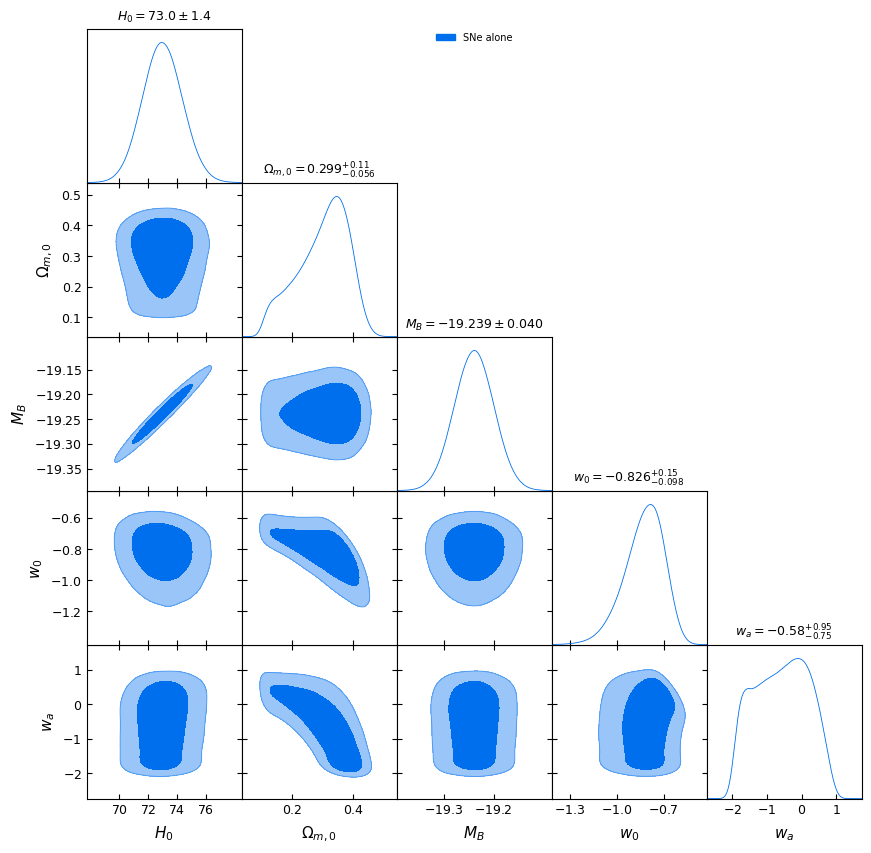

In [8]:
# =========================
# GetDist
# =========================

param_names  = ["H0", "Omega_m0", "MB", "w0", "wa"]
param_labels = [r"H_0", r"\Omega_{m,0}", r"M_B", r"w_0", r"w_a"]

samples = MCSamples(
    samples=flat_samples,
    names=param_names,
    labels=param_labels
)

samples.updateSettings({
    "smooth_scale_1D": 0.25,
    "smooth_scale_2D": 0.25,
    "fine_bins": 1024,
    "fine_bins_2D": 1024

})

# samples.setRanges({
#     "H0": (50, 90),
#     "Omega_m": (0.1, 0.6)
# })

g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.settings.legend_fontsize = 10
g.settings.linewidth_contour = 1.2
g.settings.num_plot_contours = 2
g.settings.axis_marker_lw = 1.0
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.3

# Triangle plot
g.triangle_plot(
    samples,
    filled=True,
    legend_labels=["SNe alone"],
    #contour_colors=["#"],
    title_limit=1
)

plt.savefig("triangle_CPL_sne.png", dpi=300, bbox_inches="tight")
plt.show()